**Capstone Project – The Battle of the Neighborhoods (Week 1 and Week 2)**

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

**1. Introduction/Business Problem**:

**Background**:

Canada has one of the hottest real estate markets in the world. Cities like Vancouver and Toronto lead the charts in terms of expensive housing in the country. Toronto attracts a lot of people from different part of the country and as well as the world as its technological hub is constantly growing and thriving. With ever increasing population in the Greater Toronto Area, the real estate market is having a hard time meeting the demand. This has resulted in the housing prices skyrocketing in the last few years. 

**Business Problem**:

Given the limited supply of housing and ever-increasing prices, it is imperative that people make an informed decision while buying a property.

This capstone project will explore the average prices of different neighborhoods in Toronto, analyze different venues in each of those neighborhoods and determine which venue categories, such as restaurants, schools, public transport and so on, have the most impact on housing prices. At the end, the top five categories that seem to affect housing prices will be summarized. 


**Target Audience**:

The results from this project should be very helpful to the general public that includes buyers and real estate agents who could use it as a potential tool to decide which neighborhood would be good to purchase a property in.


**2. Data Section**:

For this capstone project, we need to gather data from few different sources. The sources are listed below:

1.	We need to gather all the postal code information for the city of Toronto. Data for this will be scraped from this link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
2.	The data for average prices in Toronto based on postal codes can be obtained from this link: https://housepricehub.com/cities/city/Toronto. The sample, for example, will look like below:

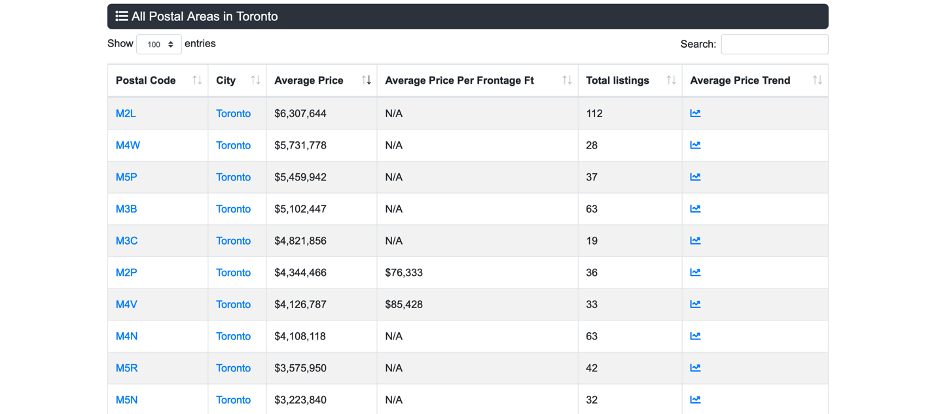
 

3.	We will also need to gather data about different venues, categories for each of the neighborhoods. This can be achieved by using the Foursquare API data. The data retrieved from Foursquare API will include neighborhood, latitude, longitude, name of the venue, category, etc. A sample of data obtained from Foursquare is shown below:

 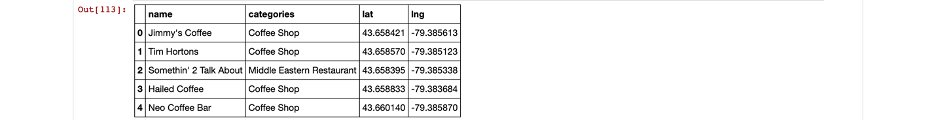


**Import neighborhood data for Toronto from Wikipedia and clean up the data so that it can be used for further anaylsis**.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install BeautifulSoup4
from bs4 import BeautifulSoup

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


In [2]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [3]:
url_link = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
url_source = requests.get(url_link).text
soup = BeautifulSoup(url_source, 'html5lib')
table=soup.find('table')

In [4]:
#create a new dataframe that consists of postal code, borough and neighborhood columns
columnnames = ['Postalcode','Borough','Neighborhood']
Toronto_df = pd.DataFrame(columns = columnnames)

In [5]:
# Search all the postcode, borough, neighborhood 
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        Toronto_df.loc[len(Toronto_df)] = row_data

Toronto_df.head()

,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [6]:
#Process data such that entries that have Borough = Not Assigned are not considered
Toronto_df_updated = Toronto_df[Toronto_df.Borough != 'Not assigned']

In [7]:
#Combine Neighborhoods that have the same Postal Code
Toronto_df_clean = Toronto_df_updated.groupby(['Postalcode','Borough'], sort = False).agg(','.join)
Toronto_df_clean.reset_index(inplace=True)

In [8]:
#Replace Neighborhood fields that have "Not assigned" with the Borough name
Toronto_df_clean['Neighborhood'] = np.where(Toronto_df_clean['Neighborhood'] == 'Not assigned',Toronto_df_clean['Borough'], Toronto_df_clean['Neighborhood'])

In [9]:
#read the average housing prices data obtained from the url: https://housepricehub.com/cities/city/Toronto and stored in "Toronto_house_prices.csv" file
Toronto_house_prices_df = pd.read_csv('./Toronto_house_prices.csv')
Toronto_house_prices_df.head()

,Postal Code,Average Price
0,M0S,1049800
1,M1A,2200000
2,M1B,816296
3,M1C,1160552
4,M1E,937728


In [10]:
#Import latitude and longitude data
lat_long = pd.read_csv('https://cocl.us/Geospatial_data')
lat_long.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
#Combine all data imported such that all information is present in a single dataframe
lat_long.rename(columns={'Postal Code': 'Postalcode'},inplace=True)
Toronto_house_prices_df.rename(columns={'Postal Code' : 'Postalcode'},inplace=True)
dfs = [Toronto_df_clean,lat_long,Toronto_house_prices_df]
from functools import reduce
df_final = reduce(lambda left,right: pd.merge(left,right,on='Postalcode'), dfs)
df_final.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Average Price
0,M3A,North York,Parkwoods,43.753259,-79.329656,1739779
1,M4A,North York,Victoria Village,43.725882,-79.315572,1162631
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2215326
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1714409
4,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,2698405


**Methodology**:

As mentioned in the introduction section, Toronto is one of the hottest real estate markets in the world. So, in order to make an informed decision in such a market, it is important to have access to as much as detailed information as possible. In this study, we will carry out a detailed analysis of different neighborhoods in Toronto and see what kind of impact different venues and number of venues have on house prices. 

In the first step, we collected postal code, borough and neighborhood for different areas in Toronto from Wikipedia. We also collected the average house prices for each of those postal codes from the “housepricehub” website. After importing the required data, we cleaned all the data and matched all house prices data with postal code, boroughs and neighborhoods data. 

In the second step, we use k-means clustering to compare different neighborhoods and create clusters for those neighborhoods. This clustering process should give us an indication of what different clusters look like and how the average house prices in each of those clusters look like. 

In the third and final step, we use Foursquare API to gather different venues’ information for each of the neighborhoods. The data from Foursquare includes venue name, venue location (latitude and longitude), venue category, etc. The field we are interested in this study is venue category. The category assigned for each entry will be from the lowest hierarchal level for category assignment. We will be able to obtain the category hierarchal level from the Foursquare website (https://developer.foursquare.com/docs/build-with-foursquare/categories). There are over 100+ entries for entire hierarchal level. In order to understand the data, we will use the only the top level categories for all entries. The top level categories are: Arts & Entertainment, College & University, Events, Food, Nightlife Spot, Outdoor & Recreation, Professional & Other Places, Residence, Shop & Service and Travel & Transport. In order to carry out this process, we will import category data from Foursquare website and then assign main category to each of the entries.

In [12]:
df_Toronto_clusters = df_final.drop(['Postalcode','Borough','Neighborhood'],axis=1)
df_Toronto_clusters.head()

,Latitude,Longitude,Average Price
0,43.753259,-79.329656,1739779
1,43.725882,-79.315572,1162631
2,43.654260,-79.360636,2215326
3,43.718518,-79.464763,1714409
4,43.667856,-79.532242,2698405


In [13]:
from sklearn.preprocessing import StandardScaler

X = df_Toronto_clusters.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[ 0.68190723, -0.12272885],
       [ 0.82319152, -0.62160718],
       [ 0.37115582,  0.28832705],
       [-0.67333621, -0.14465831],
       [-1.35021263,  0.7058935 ],
       [ 2.03911973, -0.92097411],
       [ 0.4558959 ,  2.7839124 ],
       [ 0.87971165, -0.42101617],
       [ 0.18757823,  0.95794397],
       [-0.47582067,  0.13011945],
       [-1.57572743, -0.05084224],
       [ 2.37872905, -0.62340424],
       [ 0.56889404,  2.54137362],
       [ 0.79493346, -0.68709216],
       [ 0.22287899, -0.17526534],
       [-0.30648696, -0.24189303],
       [-1.80118605, -0.5177167 ],
       [ 2.09571309, -0.81601006],
       [ 1.04929212,  0.06323849],
       [-0.56047549, -0.69358023],
       [ 1.8127824 , -0.87371557],
       [ 0.3429108 ,  0.33152039],
       [-0.25003604, -0.0738833 ],
       [ 1.58649823, -0.89211488],
       [ 0.3429108 , -0.64135407],
       [-0.44760073, -0.1475177 ],
       [-0.44760073, -0.33671957],
       [ 1.58649823, -0.7727614 ],
       [ 0.51239296,

In [14]:
num_clusters = 5

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[3 3 0 0 0 1 4 3 0 0 2 1 4 3 0 0 2 1 3 2 1 0 0 1 3 0 0 1 3 2 3 0 1 0 2 3 0
 3 4 2 3 2 2 1 0 2 3 0 2 2 1 0 2 4 0 2 2 1 4 0 4 2 2 3 0 0 4 0 2 1 0 0 2 3
 0 0 3 4 0 2 2 3 4 2 2 1 0 0 0 2 2]


In [15]:
df_Toronto_clusters["Labels"] = labels
df_Toronto_clusters.head(5)

,Latitude,Longitude,Average Price,Labels
0,43.753259,-79.329656,1739779,3
1,43.725882,-79.315572,1162631,3
2,43.654260,-79.360636,2215326,0
3,43.718518,-79.464763,1714409,0
4,43.667856,-79.532242,2698405,0


In [16]:
df_Toronto_clusters.groupby('Labels').mean()

,Latitude,Longitude,Average Price
Labels,,,
0,43.693884,-79.415403,2.164773e+06
1,43.764024,-79.228896,1.049548e+06
2,43.691742,-79.517243,1.211150e+06
3,43.730659,-79.319442,1.320387e+06
4,43.716190,-79.383470,4.834319e+06


In [17]:
df_final.insert(0, 'Cluster Labels', k_means.labels_)
df_final.head()

,Cluster Labels,Postalcode,Borough,Neighborhood,Latitude,Longitude,Average Price
0,3,M3A,North York,Parkwoods,43.753259,-79.329656,1739779
1,3,M4A,North York,Victoria Village,43.725882,-79.315572,1162631
2,0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2215326
3,0,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1714409
4,0,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,2698405


In [40]:
# create map
neighborhood_latitude  = 43.6658599 
neighborhood_longitude = -79.38315990000001
map_clusters = folium.Map(location=[neighborhood_latitude,neighborhood_longitude],zoom_start=10)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighborhood, cluster in zip(df_final['Latitude'], df_final['Longitude'], df_final['Neighborhood'], df_final['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**The imported dataframe cotains more than 100 different postal codes. It is easier to break down the analysix if the dataframes are split based on the five borough in the city i.e. Toronto, North York, East York, Etobicoke and Scarborough. The Toronto borough dataset contain the most postal codes and covers different clusters from the above map, so we will analyze the Toronto borough in our study**.

In [19]:
Toronto_Borough_data = df_final[df_final['Borough'].str.contains("Toronto")]
Toronto_Borough_data.head()

,Cluster Labels,Postalcode,Borough,Neighborhood,Latitude,Longitude,Average Price
2,0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2215326
8,0,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2990000
14,0,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1679000
18,3,M4E,East Toronto,The Beaches,43.676357,-79.293031,1954923
22,0,M6G,Downtown Toronto,Christie,43.669542,-79.422564,1796288


**Analysis of Toronto Borough Data. The first step is to visualize all postal codes in the borough using Folim map**.

In [20]:
address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [24]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough,neighborhood in zip(Toronto_Borough_data['Latitude'], Toronto_Borough_data['Longitude'],Toronto_Borough_data['Borough'], Toronto_Borough_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

**The next step is to gather venue information data for Toronto Borough from Foursquare API. The credentials required to obtain Foursquare data is listed below**.

In [21]:
CLIENT_ID = 'BCRJAFBBWJX0FCUTENRD4VWGVJ4ZQKNNJL0AZQHYMYPR0JHI' # your Foursquare ID
CLIENT_SECRET = 'FXFUBQ3NMXFL0TW5QVTALFLHGRAOMJ2LDJM0F0JPHNDMQBAI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BCRJAFBBWJX0FCUTENRD4VWGVJ4ZQKNNJL0AZQHYMYPR0JHI
CLIENT_SECRET:FXFUBQ3NMXFL0TW5QVTALFLHGRAOMJ2LDJM0F0JPHNDMQBAI


In [25]:
#borrow the get_category_type
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [26]:
#Use the foursquare api to query venue information for all the postal codes in Toronto.
venues_dict = dict()
for ind in Toronto_Borough_data.index:
    neighborhood_latitude = Toronto_Borough_data['Latitude'][ind] # neighborhood latitude value
    neighborhood_longitude = Toronto_Borough_data['Longitude'][ind]
    #print("lat:",neighborhood_latitude)
    #print("long:",neighborhood_longitude)
    LIMIT = 100
    radius = 500
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']

    nearby_venues = pd.json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row 
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type,axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    #print("nearby:",nearby_venues)
    venues_dict.update({Toronto_Borough_data['Postalcode'][ind]:nearby_venues})   

In [27]:
#scrape categories info from Foursquare API 
import requests
url_link_1 = 'https://api.foursquare.com/v2/venues/categories?client_id=BCRJAFBBWJX0FCUTENRD4VWGVJ4ZQKNNJL0AZQHYMYPR0JHI&client_secret=FXFUBQ3NMXFL0TW5QVTALFLHGRAOMJ2LDJM0F0JPHNDMQBAI&v=20180605'
#querystring = {"prefix":"shortname"}
response1 = requests.get(url_link_1).json()
#response1

In [28]:
#After scraping venue category information from Foursquare API we need to create proper sub-categories based on main categories. 
from pandas import DataFrame
venues_cat = dict()

subvenues_cat = []
mainvenues_cat = []
table_1 = table()
for i in range(0,10):
    main_cat = response1['response']['categories'][i]['name']
    values = response1['response']['categories'][i]['categories']
    #print(values)
    for j in range(len(values)):
        if not (len(response1['response']['categories'][i]['categories'][j]['categories'])) ==0:
            values_1 = response1['response']['categories'][i]['categories'][j]['categories']
            for k in range(len(values_1)):
                vales2 = response1['response']['categories'][i]['categories'][j]['categories'][k]['name']
                subvenues_cat.append(vales2)
                if not (len(response1['response']['categories'][i]['categories'][j]['categories'][k]['categories'])) ==0:
                    values_3 = response1['response']['categories'][i]['categories'][j]['categories'][k]['categories']
                    for l in range(len(values_3)):
                        vales3 = response1['response']['categories'][i]['categories'][j]['categories'][k]['categories'][l]['name']
                        subvenues_cat.append(vales3)
                            
    values_table = pd.json_normalize(values)
    list_1 = values_table['name'].tolist()
    mainvenues_cat.extend(list_1)
    for val in subvenues_cat:
        mainvenues_cat.append(val)
    venues_cat.update({main_cat:mainvenues_cat})
    
    mainvenues_cat = []
    subvenues_cat = []

In [29]:
#Create a function that assigns main category based on existing categories values
def assign_category(key,category_values,df_venues_list):
    for i in range(len(category_values)):
        for rows in range(len(df_venues_list)):
            if df_venues_list.loc[rows,'categories'] == category_values[i]:
                df_venues_list.loc[rows,'Main_category'] = key
    return df_venues_list

In [42]:
#create a dictionary that contains the Venue category information that can be used assign main category based on sub-category.
for i in range(len(venues_cat.keys())):
    key = list(venues_cat.keys())[i]
    category_values = list(venues_cat.values())[i]
    for j in range(len(venues_dict.keys())):
        df_venues_list = list(venues_dict.values())[j]
        df_venues_test = assign_category(key,category_values,df_venues_list)   
            
        venues_dict.update({list(venues_dict.keys())[j]:df_venues_test})

df_venues_test

,name,categories,lat,lng,Main_category
0,Storm Crow Manor,Theme Restaurant,43.666840,-79.381593,Food
1,DanceLifeX Centre,Dance Studio,43.666956,-79.385297,Arts & Entertainment
2,The Alley,Bubble Tea Shop,43.665922,-79.385567,Food
3,Glad Day Bookshop,Bookstore,43.665271,-79.380785,Shop & Service
4,Smith,Breakfast Spot,43.666927,-79.381421,Food
5,Fabarnak,Restaurant,43.666377,-79.380964,Food
6,Bar Volo,Beer Bar,43.665462,-79.385692,Nightlife Spot
7,Sansotei Ramen 三草亭,Ramen Restaurant,43.666735,-79.385353,Food
8,Como En Casa,Mexican Restaurant,43.665160,-79.384796,Food
9,Barbara Hall Park,Park,43.666879,-79.381068,Outdoors & Recreation


In [31]:
#After assign main category, now we need to count how many venues of each category exist in a given area/postal code.
#Once processed, this information is then stored in dictionary to be subsequently used for plotting charts.
category_count = dict()
for i in range((len(venues_dict.keys()))):
    Postalcode_key = list(venues_dict.keys())[i]
    postal_values = list(venues_dict.values())[i]
    df_count = postal_values.groupby(['Main_category']).size().reset_index(name='count')
    category_count.update({Postalcode_key:df_count})

In [32]:
#Create bar and line plots for "Student life" category based on College & Universities, Professional & Other Places and Residence categories

student_life_list = ['College & University','Professional & Other Places','Residence', 'Arts & Entertainment', 'Event','Nightlife Spot']
#print(Toronto_Borough_data)
#print("dict values")
#print(list(category_count.keys())[0],list(category_count.values())[0])
df_student_life = Toronto_Borough_data[['Average Price','Postalcode']]
df_student_life[['College & University','Professional & Other Places','Residence', 'Arts & Entertainment', 'Event','Nightlife Spot']] = 0

#Loop through all postal codes in the dictionary to get the count values for the three categories we need
for l in range(len(category_count.keys())):
    postal_key = list(category_count.keys())[l]
    cat_values = list(category_count.values())[l]
    for m in range(len(student_life_list)):
        for rows in range(len(cat_values)):
            if cat_values.loc[rows,'Main_category']==student_life_list[m]:
                df_student_life.iloc[l, df_student_life.columns.get_loc(student_life_list[m])] = cat_values.loc[rows,'count']

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan


In [33]:
#Create bar and line plots for "Outdoor life" category

outdoor_life_list = ['Outdoors & Recreation','Travel & Transport','Shop & Service','Food']
#print(Toronto_Borough_data)
#print("dict values")
#print(list(category_count.keys())[0],list(category_count.values())[0])
df_outdoor_life = Toronto_Borough_data[['Average Price','Postalcode']]
df_outdoor_life[['Outdoors & Recreation','Travel & Transport','Shop & Service','Food']] = 0

#Loop through all postal codes in the dictionary to get the count values for the three categories we need
for l in range(len(category_count.keys())):
    postal_key_1 = list(category_count.keys())[l]
    cat_values_1 = list(category_count.values())[l]
    for m in range(len(outdoor_life_list)):
        for rows in range(len(cat_values_1)):
            if cat_values_1.loc[rows,'Main_category']==outdoor_life_list[m]:
                df_outdoor_life.iloc[l, df_outdoor_life.columns.get_loc(outdoor_life_list[m])] = cat_values_1.loc[rows,'count']

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


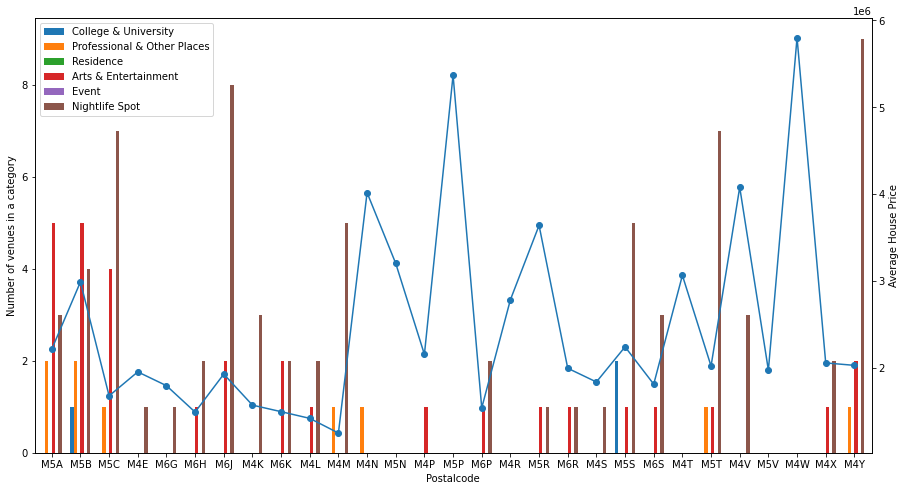

In [46]:
import matplotlib.pyplot as plt
#Use the data to plot different categories and average price for each area (based on postal code)
df_student_bar = df_student_life[['Postalcode','Average Price','College & University','Professional & Other Places','Residence', 'Arts & Entertainment', 'Event','Nightlife Spot']]
df_student_bar.set_index('Postalcode', inplace=True)
df_student_bar[['College & University','Professional & Other Places','Residence', 'Arts & Entertainment', 'Event','Nightlife Spot']].plot(kind='bar',width =0.7,figsize=(15,8))
plt.ylabel('Number of venues in a category')
df_student_bar['Average Price'].plot(marker='o',secondary_y=True)
plt.ylabel('Average House Price')

plt.savefig('Bar_chart.png')
plt.savefig('Bar_chart.pdf')
plt.show()

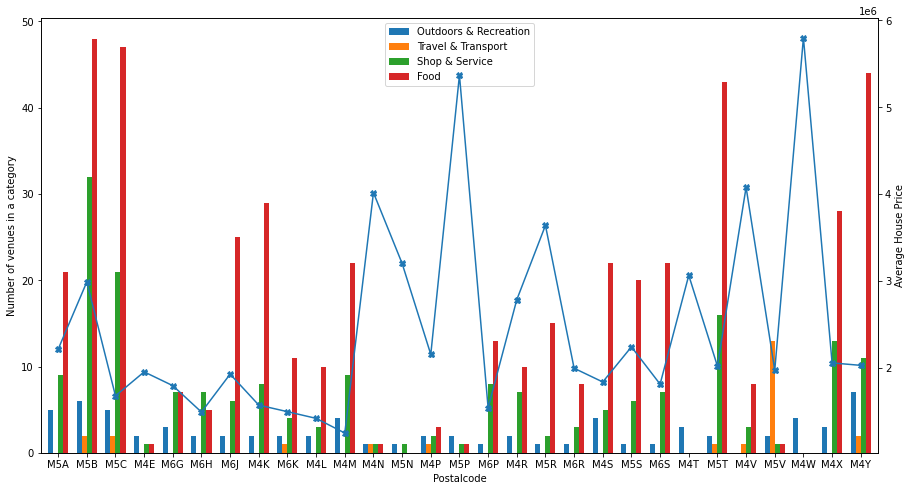

In [47]:
import matplotlib.pyplot as plt
#Use the data to plot different categories and average price for each area (based on postal code)
df_outdoor_bar = df_outdoor_life[['Postalcode','Average Price','Outdoors & Recreation','Travel & Transport','Shop & Service','Food']]
df_outdoor_bar.set_index('Postalcode', inplace=True)
df_outdoor_bar[['Outdoors & Recreation','Travel & Transport','Shop & Service','Food']].plot(kind='bar',width =0.7,figsize=(15,8))
plt.ylabel('Number of venues in a category')
df_outdoor_bar['Average Price'].plot(marker='X',secondary_y=True)
plt.ylabel('Average House Price')

plt.savefig('Bar_chart_1.png')
plt.savefig('Bar_chart_1.pdf')
plt.show()

In [36]:
#Now that we have look at individual categories, let's plot the total venues in each postal code area
#to see how that varies with average house prices.

df_Toronto_final = pd.merge(df_outdoor_bar,df_student_bar,on='Postalcode')
#df_Toronto_final.drop(['Average Price_y'],axis=1)
#df_Toronto_final.rename(columns={'Average Price_x':'Average Price'})
column_list = ['College & University','Professional & Other Places','Residence', 'Arts & Entertainment', 'Event','Nightlife Spot','Outdoors & Recreation','Travel & Transport','Shop & Service','Food']
df_Toronto_final["Total Venues"] = df_Toronto_final[column_list].sum(axis=1)
df_Toronto_final.drop(['College & University','Professional & Other Places','Residence', 'Arts & Entertainment', 'Event','Nightlife Spot','Outdoors & Recreation','Travel & Transport','Shop & Service','Food'],axis=1,inplace=True)
df_Toronto_plot = df_Toronto_final.drop(['Average Price_y'],axis=1)
df_Toronto_plot = df_Toronto_plot.rename(columns={'Average Price_x':'Average Price'})

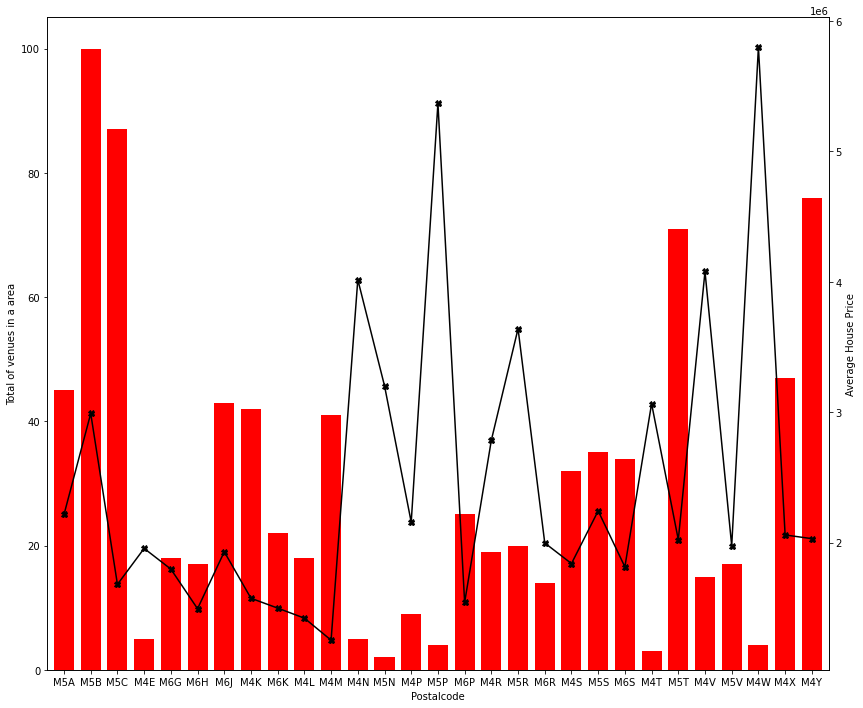

In [48]:
import matplotlib.pyplot as plt
df_Toronto_plot['Total Venues'].plot(kind='bar',width = 0.75,figsize=(14,12),color='red')
plt.ylabel('Total of venues in a area')
df_Toronto_plot['Average Price'].plot(marker='X',secondary_y=True,color='black')
plt.ylabel('Average House Price')
plt.savefig('Bar_chart_2.png')
plt.savefig('Bar_chart_2.pdf')

plt.show()